In [1]:
import json

from transformers import AutoTokenizer, AutoModel
import torch
import pandas as pd
from matplotlib import pyplot
import numpy as np
import seaborn as sns
from sklearn.metrics.pairwise import euclidean_distances, cosine_distances, cosine_similarity
from unidecode import unidecode

In [2]:
# load tokenizer and model using bert romanian cased model
# https://github.com/dumitrescustefan/Romanian-Transformers
# https://huggingface.co/dumitrescustefan/bert-base-romanian-cased-v1

tokenizer = AutoTokenizer.from_pretrained("dumitrescustefan/bert-base-romanian-cased-v1")
model = AutoModel.from_pretrained("dumitrescustefan/bert-base-romanian-cased-v1")

Some weights of the model checkpoint at dumitrescustefan/bert-base-romanian-cased-v1 were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [3]:
data = pd.read_pickle("data.pkl")

In [4]:
def create_embeddings(model, data):
    embeddings = []
    for doc in data:
        _tokens = tokenizer.encode(doc, add_special_tokens=True, return_tensors="pt")
#         for k in _tokens:
#             print(tokenizer.decode(k))
        _tokens_embeddings = model(_tokens)[0]
        _tokens_embeddings_mean = np.mean(_tokens_embeddings.detach().numpy().squeeze(), axis=0)
        embeddings.append(_tokens_embeddings_mean)
    embeddings = np.array(embeddings)
    return embeddings

In [5]:
embeddings = create_embeddings(model, data.description)
clean_embeddings = create_embeddings(model, data.clean_description)
clean_embeddings2 = create_embeddings(model, data.clean_description2)
clean_embeddings3 = create_embeddings(model, data.clean_description3)
clean_embeddings4 = create_embeddings(model, data.clean_description4)

In [6]:
def get_similarity_matrix(embeddings, metric=cosine_distances):
    x = pd.DataFrame(metric(embeddings, embeddings))    
    x =x.round(decimals=2)
    
    mask = np.triu(x.corr())
    mask = None

    fig, ax = pyplot.subplots(figsize=(15,15))
    ax.hlines([3, 6, 9], *ax.get_xlim())

    cmap = sns.cm.rocket_r
    sns.heatmap(x, linewidth=0.5, annot=True, ax=ax, cmap=cmap, mask=mask)
    
    return x

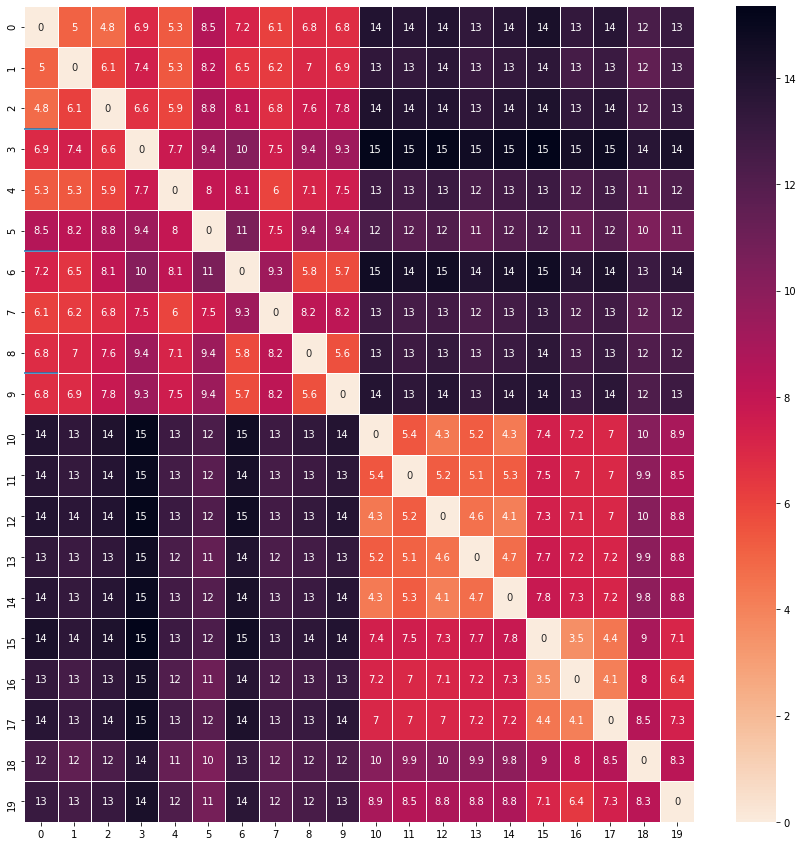

In [7]:
m = get_similarity_matrix(embeddings, euclidean_distances)

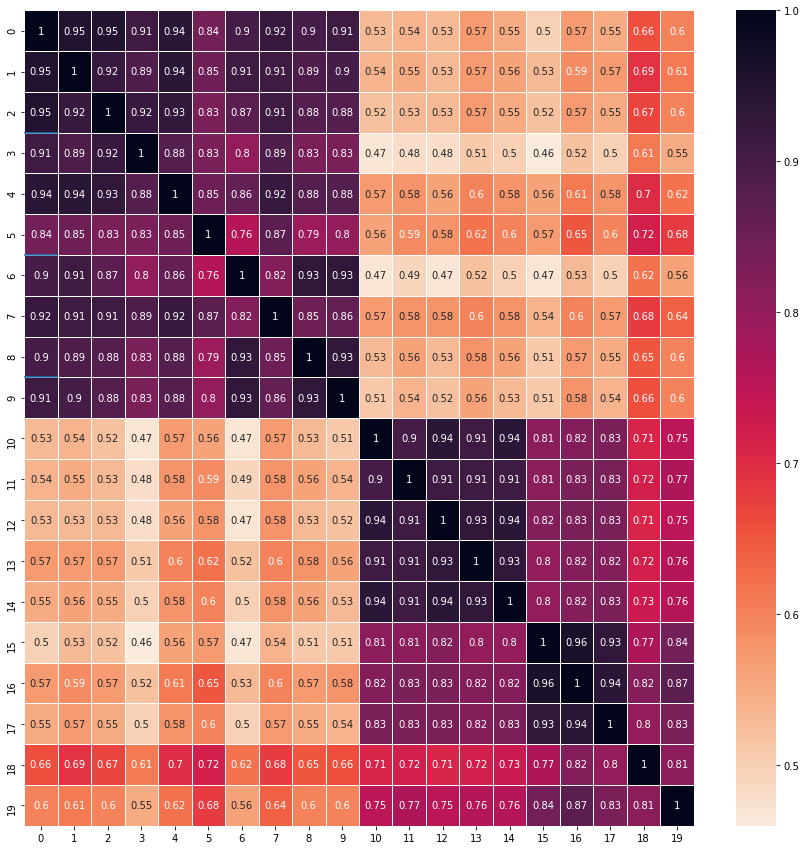

In [8]:
m = get_similarity_matrix(embeddings, cosine_similarity)

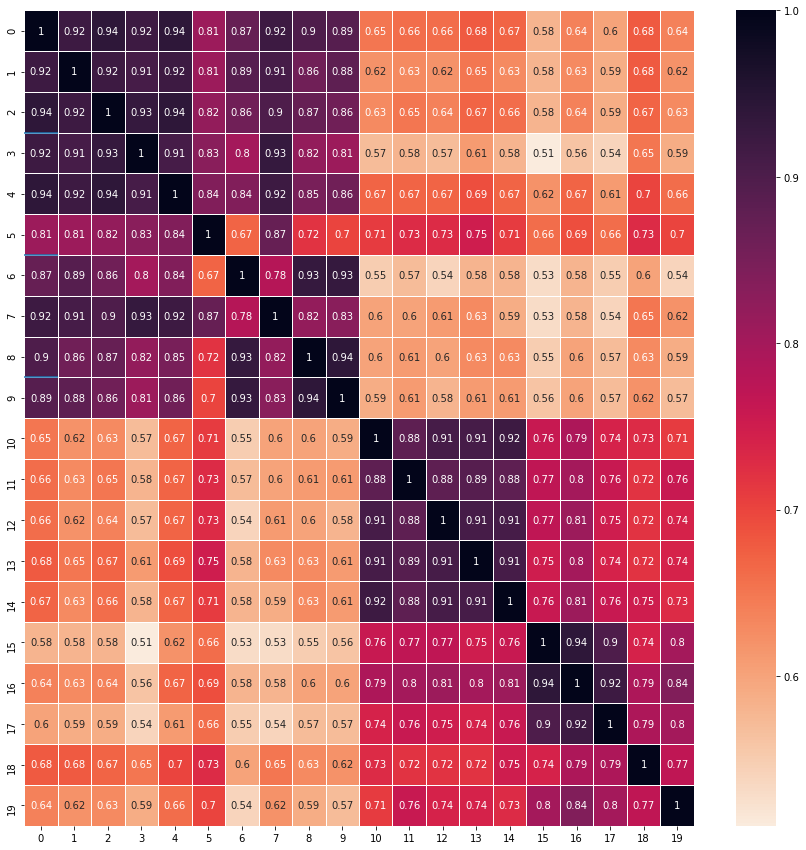

In [9]:
m = get_similarity_matrix(clean_embeddings, cosine_similarity)

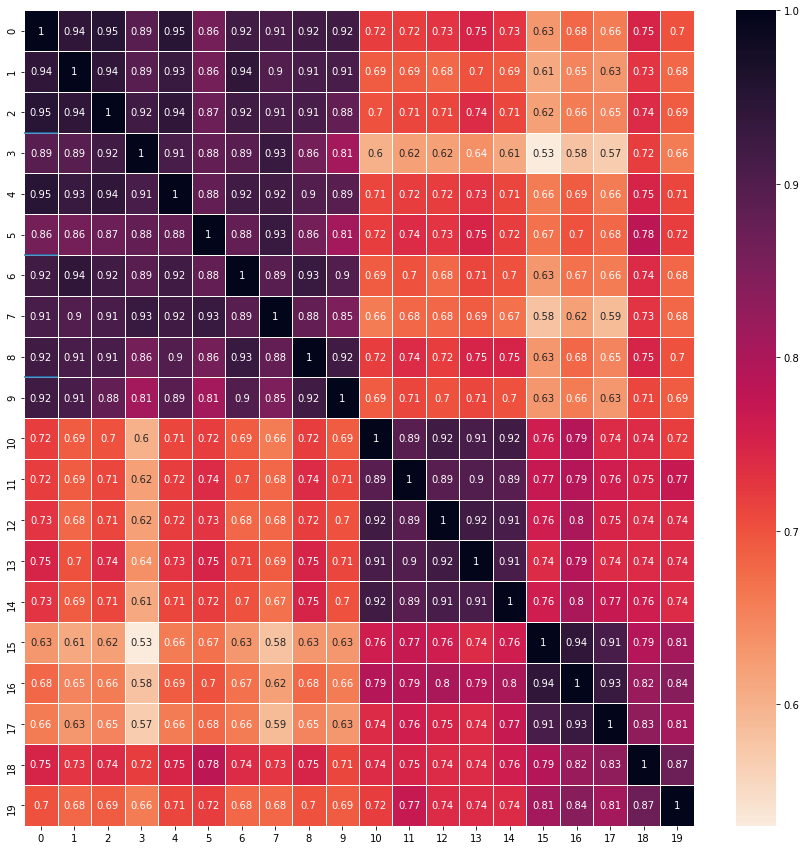

In [10]:
m = get_similarity_matrix(clean_embeddings2, cosine_similarity)

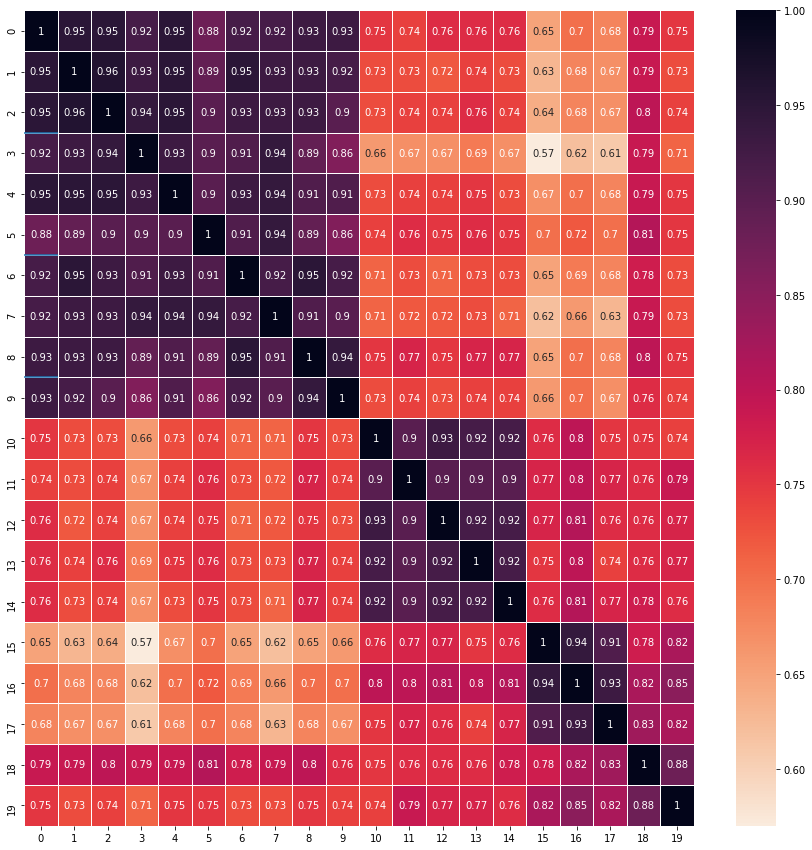

In [11]:
m = get_similarity_matrix(clean_embeddings3, cosine_similarity)

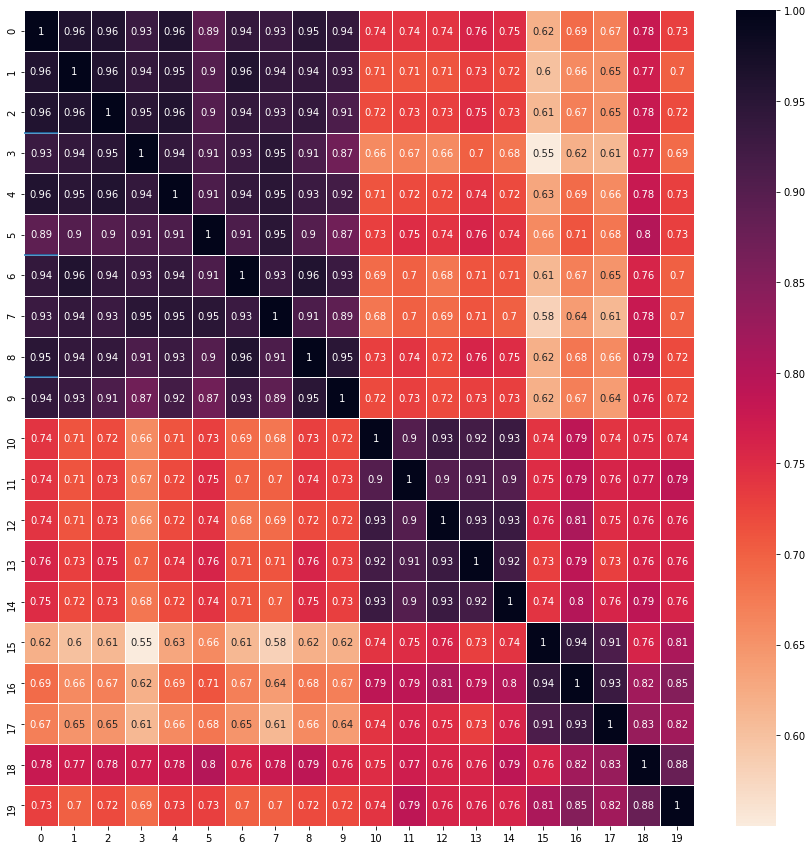

In [12]:
m = get_similarity_matrix(clean_embeddings4, cosine_similarity)

In [13]:
true_labels = ["pizza"]*5 + ["paste"]*5 + ["book"]*5 + ["dipers"]*5

for _embeddings in [embeddings, clean_embeddings, clean_embeddings2, clean_embeddings3, clean_embeddings4]:
    acc = 0
    for embedding, label in zip(_embeddings, true_labels):
        acc += (data.iloc[np.argsort(cosine_distances([embedding], _embeddings)).squeeze()].category[:5] == label).sum()/5
    #     print(acc)
    acc = acc/len(embeddings)
    print(acc)  # We get top5 sinmilarity with an accuracy of 79%

0.79
0.8100000000000002
0.8300000000000001
0.8300000000000001
0.8300000000000001
